In [ ]:
from pathlib import Path
from carps.analysis.gather_data import read_jsonl_content
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn
from dacboenv.experiment.collect_incumbents import add_metadata_to_dict
from omegaconf import OmegaConf

setup_seaborn()

def extract_from_dict(logs: pd.DataFrame, dictkey: str, key: str) -> pd.Series:
    return logs[dictkey].map(lambda x: x[key])

def load_cma_log(filename: str | Path) -> pd.DataFrame:
    logs = read_jsonl_content(filename)
    logs["cost"] = extract_from_dict(logs, "trial_value", "cost")
    logs["trial_value__additional_info"] = extract_from_dict(logs, "trial_value", "additional_info")
    logs["episode_length"] = extract_from_dict(logs, "trial_value__additional_info", "episode_length")
    logs = logs.sort_values(by="n_generation")
    return logs

rundir = "../runs/CMA-1.3"
rundir = Path(rundir)
log_filenames = list(rundir.glob("**/results.jsonl"))
logs_list = []
for log_filename in log_filenames:
    _logs = load_cma_log(log_filename)
    cfg_fn = log_filename.parent / ".hydra/config.yaml"
    cfg = OmegaConf.load(cfg_fn)
    _logs = add_metadata_to_dict(_logs, cfg)
    logs_list.append(_logs)
logs = pd.concat(logs_list).reset_index(drop=True)

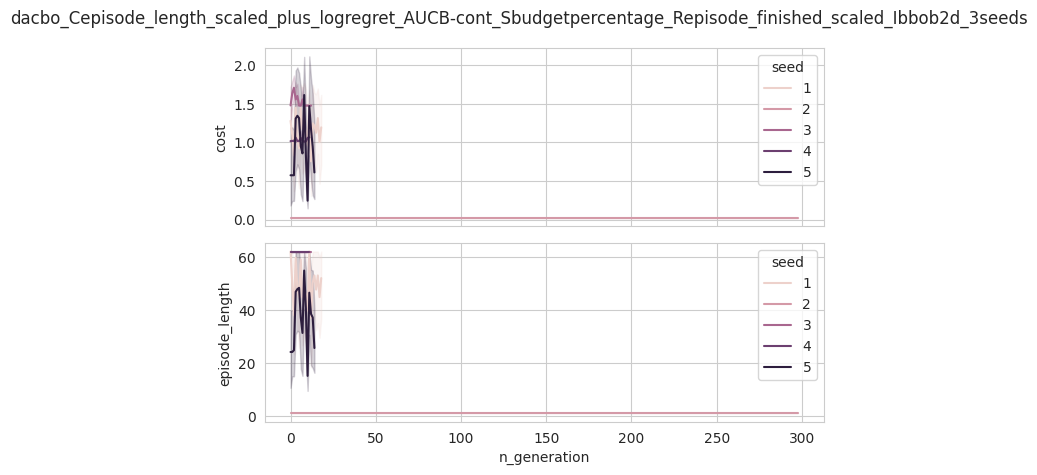

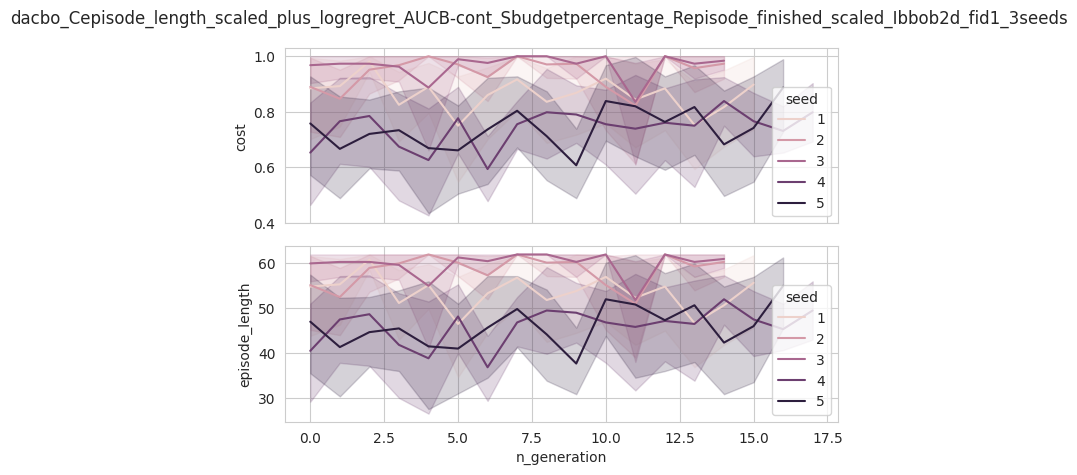

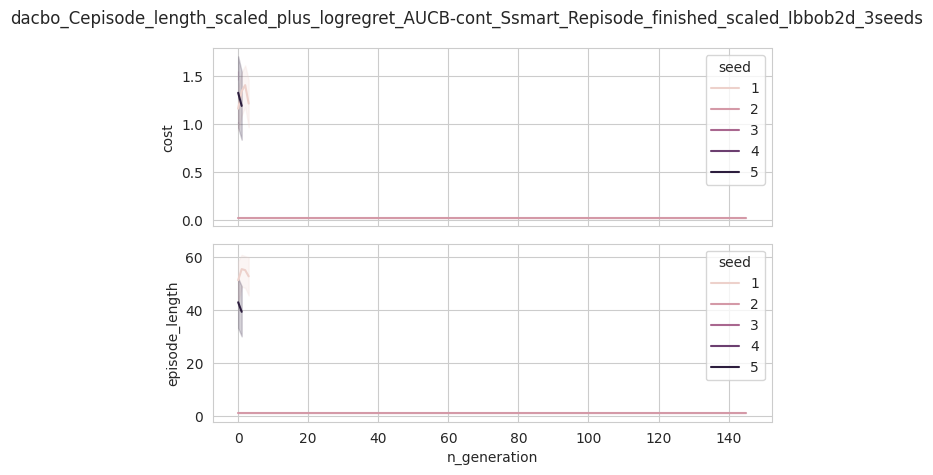

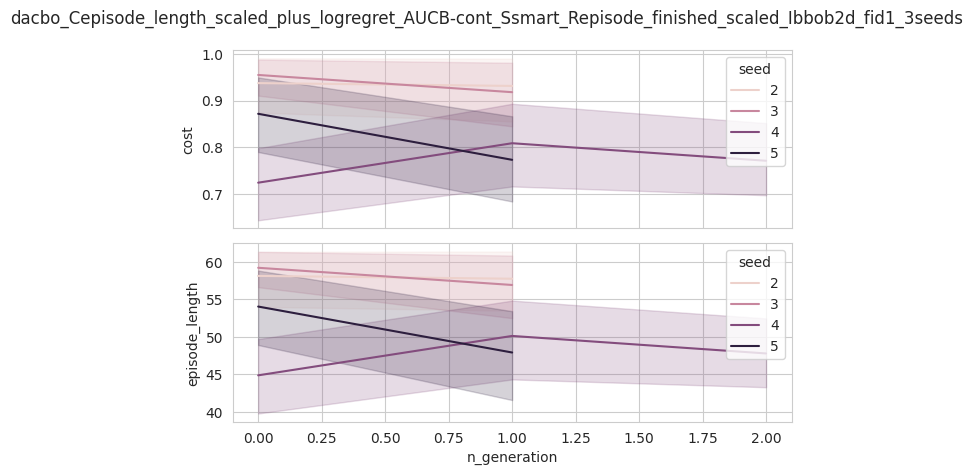

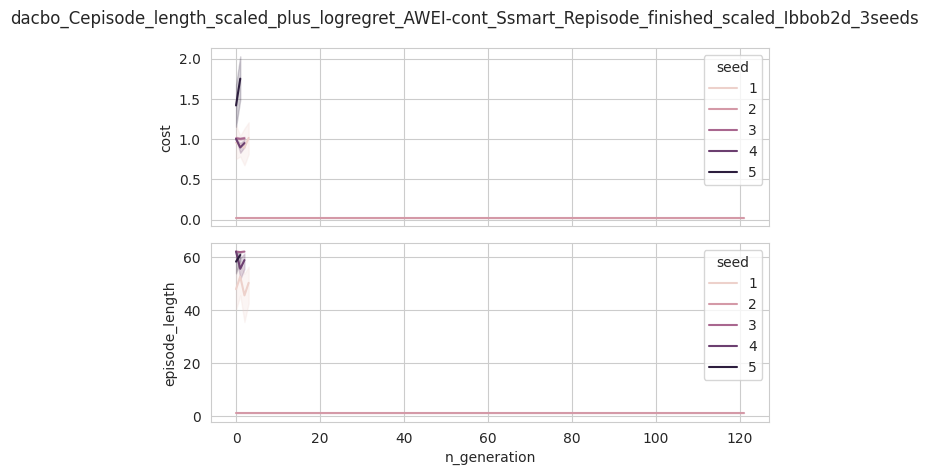

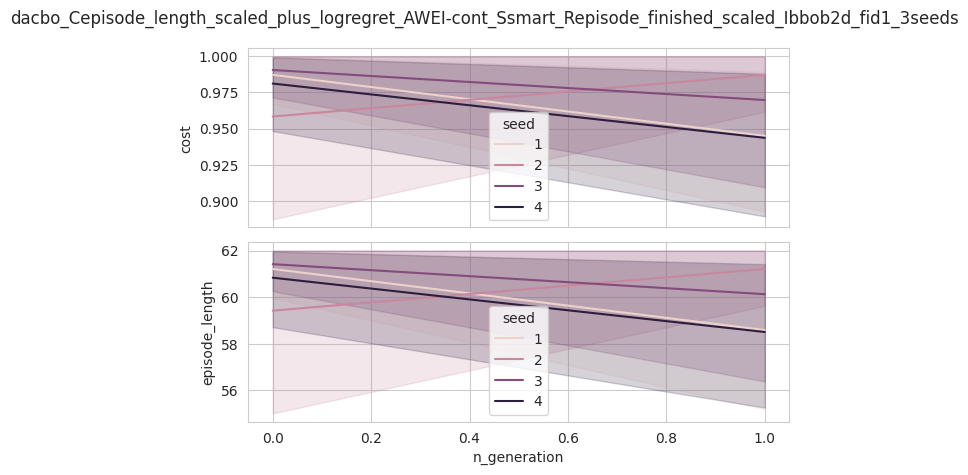

In [17]:
for task_id, group in logs.groupby("task_id"):
    fig = plt.figure()
    axes = fig.subplots(nrows=2, ncols=1, sharex=True, sharey=False)
    sns.lineplot(data=group, x="n_generation", y="cost", ax=axes[0], hue="seed")
    sns.lineplot(data=group, x="n_generation", y="episode_length", ax=axes[1], hue="seed")
    fig.suptitle(task_id)
    fig.tight_layout()
    plt.show()